Copyright (c) 2019 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book-3rd-edition

[MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Python. Uczenie maszynowe - kod źródłowy

# Rozdział 5. Kompresja danych poprzez redukcję wymiarowości

Zwróć uwagę, że rozszerzenie zawierające nieobowiązkowy znak wodny stanowi niewielki plugin notatnika IPython / Jupyter, który zaprojektowałem w celu powielania kodu źródłowego. Wystarczy pominąć poniższe wiersze kodu:

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka" -u -d -p numpy,scipy,matplotlib,sklearn

Sebastian Raschka 
last updated: 2020-03-04 

numpy 1.18.1
scipy 1.4.1
matplotlib 3.1.0
sklearn 0.22


*Korzystanie z rozszerzenia `watermark` nie jest obowiązkowe. Możesz je zainstalować za pomocą polecenia:*  

    conda install watermark -c conda-forge  

lub  

    pip install watermark   

*Więcej informacji znajdziesz pod adresem: https://github.com/rasbt/watermark.*

<br>
<br>

### Spis treści

- [Nienadzorowana redukcja wymiarowości za pomocą analizy głównych składowych](#Nienadzorowana-redukcja-wymiarowości-za-pomocą-analizy-głównych-składowych)
  - [Podstawowe etapy analizy głównych składowych](#Podstawowe-etapy-analizy-głównych-składowych)
  - [Wydobywanie głównych składowych krok po kroku](#Wydobywanie-głównych-składowych-krok-po-kroku)
  - [Wyjaśniona wariancja całkowita](#Wyjaśniona-wariancja-całkowita)
  - [Transformacja cech](#Transformacja-cech)
  - [Analiza głównych składowych w interfejsie scikit-learn](#Analiza-głównych-składowych-w-interfejsie-scikit-learn)
- [Nadzorowana kompresja danych za pomocą liniowej analizy dyskryminacyjnej](#Nadzorowana-kompresja-danych-za-pomocą-liniowej-analizy-dyskryminacyjnej)
  - [Porównanie analizy głównych składowych z liniową analizą dyskryminacyjną](#Porównanie-analizy-głównych-składowych-z-liniową-analizą-dyskryminacyjną)
  - [Wewnętrzne mechanizmy działania liniowej analizy dyskryminacyjnej](#Wewnętrzne-mechanizmy-działania-liniowej-analizy-dyskryminacyjnej)
  - [Obliczanie macierzy rozproszenia](#Obliczanie-macierzy-rozproszenia)
  - [Dobór dyskryminant liniowych dla nowej podprzestrzeni cech](#Dobór-dyskryminant-liniowych-dla-nowej-podprzestrzeni-cech)
  - [Rzutowanie przykładów na nową przestrzeń cech](#Rzutowanie-przykładów-na-nową-przestrzeń-cech)
  - [Implementacja analizy LDA w bibliotece scikit-learn](#Implementacja-analizy-LDA-w-bibliotece-scikit-learn)
- [Jądrowa analiza głównych składowych jako metoda odwzorowywania nierozdzielnych liniowo klas](#Jądrowa-analiza-głównych-składowych-jako-metoda-odwzorowywania-nierozdzielnych-liniowo-klas)
  - [Funkcje jądra oraz sztuczka z funkcją jądra](#Funkcje-jądra-oraz-sztuczka-z-funkcją-jądra)
  - [Implementacja jądrowej analizy głównych składowych w Pythonie](#Implementacja-jądrowej-analizy-głównych-składowych-w-Pythonie)
    - [Przykład 1. Rozdzielanie sierpowatych kształtów](#Przykład-1.-Rozdzielanie-sierpowatych-kształtów)
    - [Przykład 2. Rozdzielanie koncentrycznych kręgów](#Przykład-2.-Rozdzielanie-koncentrycznych-kręgów)
  - [Rzutowanie nowych punktów danych](#Rzutowanie-nowych-punktów-danych)
  - [Algorytm jądrowej analizy głównych składowych w bibliotece scikit-learn](#Algorytm-jądrowej-analizy-głównych-składowych-w-bibliotece-scikit-learn)
- [Podsumowanie](#Podsumowanie)

<br>
<br>

In [1]:
from IPython.display import Image
%matplotlib inline

# Nienadzorowana redukcja wymiarowości za pomocą analizy głównych składowych

## Podstawowe etapy analizy głównych składowych

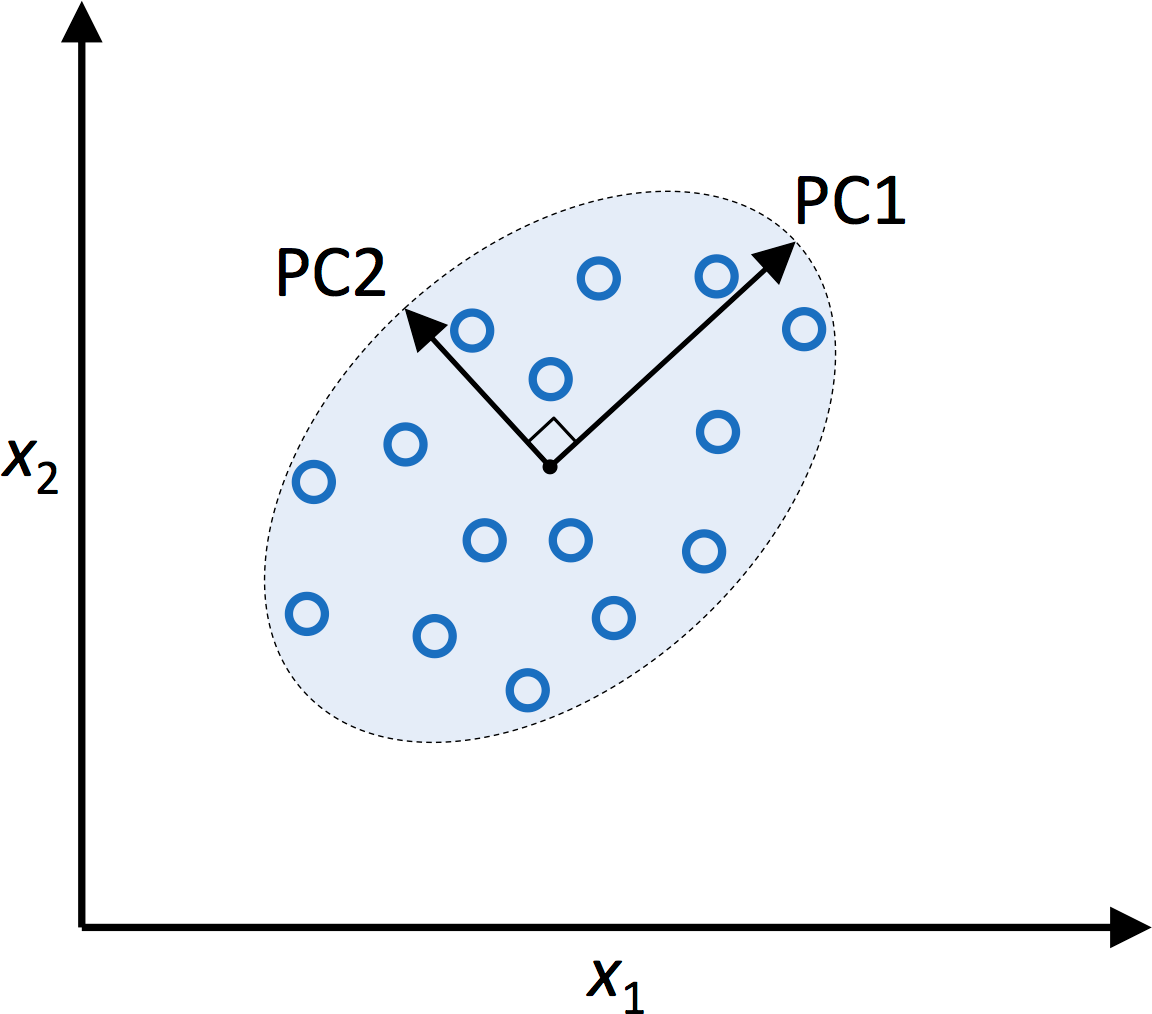

In [2]:
Image(filename='rysunki/05_01.png', width=400) 

## Wydobywanie głównych składowych krok po kroku

In [4]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

# jeżeli zestaw danych Wine będzie tymczasowo niedostępny w repozytorium UCI,
# usuń znak komentarza z poniższego wiersza, aby wczytać ten zestaw z katalogu lokalnego:

# df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Etykieta klas', 'Alkohol', 'Kwas jabłkowy', 'Popiół',
                   'Zasadowość popiołu', 'Magnez', 'Całk. zaw. fenoli',
                   'Flawonoidy', 'Fenole nieflawonoidowe', 'Proantocyjaniny',
                   'Intensywność koloru', 'Odcień', 'Transmitancja 280/315 nm',
                   'Prolina']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


<hr>

Rozdzielanie danych na 70% podzbiorów uczących i 30% testowych.

In [5]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

Standaryzowanie danych.

In [6]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

---

**Uwaga**

Przez przypadek wprowadziłem zapis `X_test_std = sc.fit_transform(X_test)` zamiast `X_test_std = sc.transform(X_test)`. W tym przypadku nie odczujemy wielkiej róznicy, ponieważ wartość średnia i odchylenie standardowe zestawu testowego powinny mieć podobne wartości, jak w przypadku zestawu uczącego. Jak jednak pamiętamy z rozdziału 3., właściwym rozwiązaniem jest ponowne wykorzystanie parametrów zestawu uczącego w celu przeprowadzenia jakiejkolwiek transformacji -- zestaw danych testowych powinien pełnić funkcję "nowych, nieznanych" przykładów.

Jest to powszechny błąd popełniany przez wiele osób, które *nie* wykorzystują parametrów otrzymanych z uczenia / tworzenia modelu i standaryzują dane "od podstaw". Poniżej wyjaśniam, dlaczego może to stanowić problem.

Załóżmy, że mamy jakiś prosty zestaw uczący składający się z trzech przykładów i jednej cechy (nazwijmy ją sobie "długość"):

- train_1: 10 cm -> class_2
- train_2: 20 cm -> class_2
- train_3: 30 cm -> class_1

wartość średnia: 20, odchylenie standardowe: 8.2

Po przeprowadzeniu standaryzacji, wartości przekształconej cechy są następujące:

- train_std_1: -1.21 -> class_2
- train_std_2: 0 -> class_2
- train_std_3: 1.21 -> class_1

Przyjmijmy teraz, że nasz model nauczył się klasyfikować przykłady za pomocą ustandaryzowanej wartości cechy < 0,6 dla klasy 2 (w przeciwnym wypadku przykłady należą do klasy 1). Jak na razie wszystko się zgadza. Powiedzmy teraz, że mamy trzy nieopisane punkty danych, które chcemy sklasyfikować:

- new_4: 5 cm -> class ?
- new_5: 6 cm -> class ?
- new_6: 7 cm -> class ?

Jeżeli spojrzymy na "nieustandaryzowane" wartości cechy w naszym zestawie danych uczących, to na pierwszy rzut oka stwierdzimy, że najprawdopodobniej wszystkie te przykłady będą przynależeć do klasy 2. Jeżeli jednak dokonamy standaryzacji tychże danych poprzez ponowne obliczenie odchylenia standardowego i średniej, otrzymamy podobne wartości, jak w przypadku zbioru uczącego, a klasyfikator zidentyfikowałby (raczej niepoprawnie) przykłady 4 i 5 jako elementy klasy 2.

- new_std_4: -1.21 -> class 2
- new_std_5: 0 -> class 2
- new_std_6: 1.21 -> class 1

Gdybyśmy jednak użyli parametrów otrzymanych ze standaryzacji zestawu uczącego, otrzymalibyśmy rezultat:

- sample5: -18.37 -> class 2
- sample6: -17.15 -> class 2
- sample7: -15.92 -> class 2

Długości 5 cm, 6 cm i 7 cm są znacznie mniejsze od wszelkich wartości znajdujących się w zestawie danych uczących. Zatem jedynym logicznym wyjaśnieniem jest stwierdzenie, że standaryzowane cechy tych "nowych przykładów" są znacznie mniejsze od analogicznych cech ze zbioru uczącego.

---

Rozkład macierzy kowariancji.

In [7]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nWartości własne \n%s' % eigen_vals)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


**Uwaga**: 

Wykorzystałem powyżej funkcję [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) do rozkładu symetrycznej macierzy kowariancji na jej wartości własne i wektory własne.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    Zasadniczo nie popełniłem tu żadnego "błędu", ale zastosowane rozwiązanie nie jest optymalne. W takich przypadkach lepiej byłoby zastosować funkcję [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html), która została zaprojektowana do przetwarzania [macierzy hermitowskich](https://pl.wikipedia.org/wiki/Macierz_hermitowska). Funkcja `numpy.linalg.eigh` zawsze zwraca rzeczywiste wartości własne, podczas gdy mniej stabilna numerycznie funkcja `np.linalg.eig` może w pewnych sytuacjach zwracać skomplikowane wartości własne podczas rozkładania niesymetrycznych macierzy kwadratowych.
(S.R.)


<br>
<br>

## Wyjaśniona wariancja całkowita

In [8]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

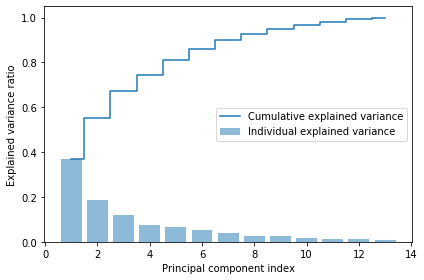

In [9]:
import matplotlib.pyplot as plt


plt.bar(range(1, 14), var_exp, alpha=0.5, align='center',
        label='Pojedyncza wariancja wyjaśniona')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Łączna wariancja wyjaśniona')
plt.ylabel('Współczynnik wariancji wyjaśnionej')
plt.xlabel('Indeks głównej składowej')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('rysunki/05_02.png', dpi=300)
plt.show()

<br>
<br>

## Transformacja cech

In [10]:
# tworzy listę krotek (wartość własna, wektor własny)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# szereguje krotki (wartość własna, wektor własny) w kolejności malejącej
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [11]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Macierz W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


**Uwaga**
W zależności od używanej wersji bibliotek NumPy i LAPACK, może być generowana macierz W z przeciwnymi znakami. To nie jest żaden błąd: jeżeli $v$ jest wektorem własnym macierzy $\Sigma$, otrzymujemy

$$\Sigma v = \lambda v,$$

gdzie $\lambda$ stanowi wartość własną,


zatem $-v$ jest również wektorem własnym o takiej samej wartości własnej, ponieważ
$$\Sigma \cdot (-v) = -\Sigma v = -\lambda v = \lambda \cdot (-v).$$

In [12]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

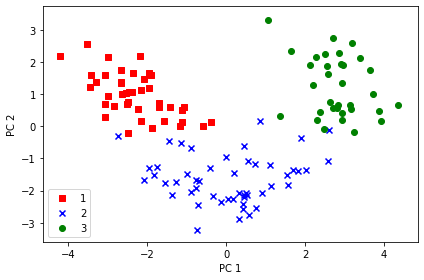

In [13]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('GS 1')
plt.ylabel('GS 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('rysunki/05_03.png', dpi=300)
plt.show()

<br>
<br>

## Analiza głównych składowych w interfejsie scikit-learn

**UWAGA**

Następne cztery komówki zostały dodane w celu ukazania sposobu powtórzenia wyników uzyskanych za pomocą implementacji analizy PCA w bibliotece scikit-learn:

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

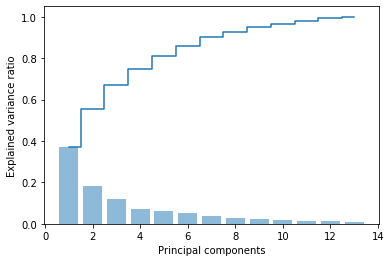

In [15]:
plt.bar(range(1, 14), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 14), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Współczynnik wariancji wyjaśnionej')
plt.xlabel('Główne składowe')

plt.show()

In [16]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

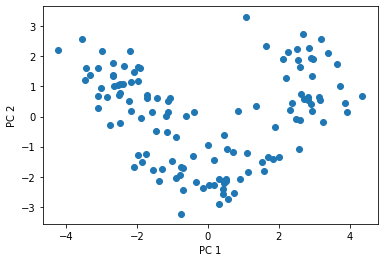

In [17]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('GS 1')
plt.ylabel('GS 2')
plt.show()

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # konfiguruje generator znaczników i mapę kolorów
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # rysuje wykres powierzchni decyzyjnej
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # rysuje wykres przykładów podzielonych na klasy
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

Uczenie klasyfikatora regresji logistycznej przy użyciu dwóch pierwszych głównych składowych.

In [19]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_pca, y_train)

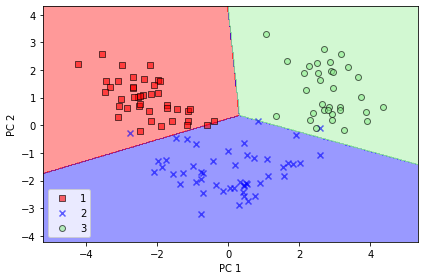

In [20]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('GS 1')
plt.ylabel('GS 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('rysunki/05_04.png', dpi=300)
plt.show()

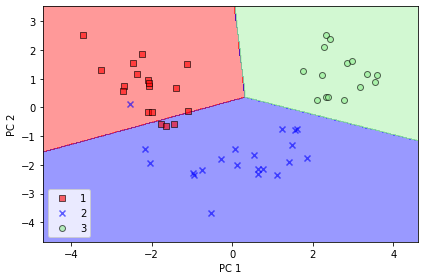

In [21]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('GS 1')
plt.ylabel('GS 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('rysunki/05_05.png', dpi=300)
plt.show()

In [22]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

<br>
<br>

# Nadzorowana kompresja danych za pomocą liniowej analizy dyskryminacyjnej

## Porównanie analizy głównych składowych z liniową analizą dyskryminacyjną

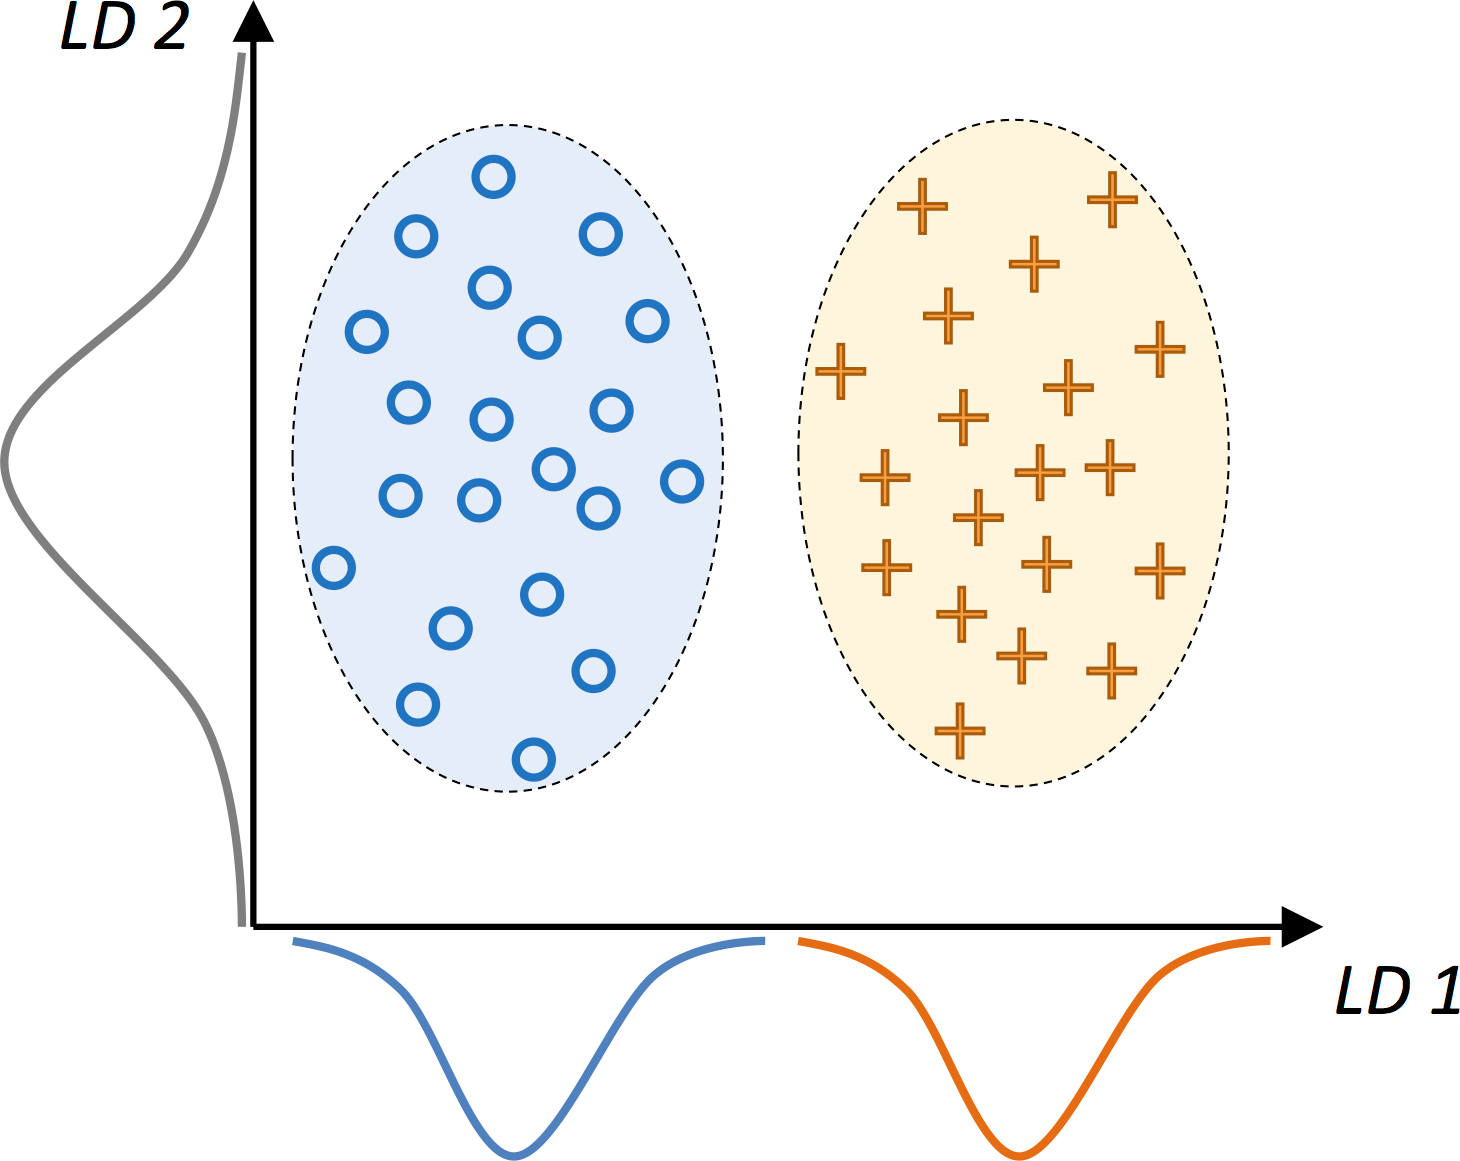

In [3]:
Image(filename='rysunki/05_06.png', width=400) 

## Wewnętrzne mechanizmy działania liniowej analizy dyskryminacyjnej

<br>
<br>

## Obliczanie macierzy rozproszenia

Obliczanie uśrednionych wektorów dla każdej klasy:

In [24]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print('UW %s: %s\n' % (label, mean_vecs[label - 1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



Obliczenie wewnątrzklasowej macierzy rozproszenia:

In [25]:
d = 13 # liczba cech
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))  # macierz rozproszenia dla każdej cechy
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)  # tworzy wektory kolumnowe
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter                          # sumuje klasy macierzy rozproszenia

print('Wewnątrzklasowa macierz rozproszenia: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


Lepiej: macierz kowariancji, gdyż klasy są nierównomiernie rozmieszczone:

In [26]:
print('Rozkład etykiet klas: %s' 
      % np.bincount(y_train)[1:])

Class label distribution: [41 50 33]


In [27]:
d = 13  # liczba cech
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print('Skalowana wewnątrzklasowa macierz rozproszenia: %sx%s' % (S_W.shape[0],
                                                     S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


Obliczanie międzyklasowej macierzy rozproszenia:

In [28]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13  # liczba cech
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # tworzy wektor kolumnowy
    mean_overall = mean_overall.reshape(d, 1)  # tworzy wektor kolumnowy
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Międzyklasowa macierz rozproszenia: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


<br>
<br>

## Dobór dyskryminant liniowych dla nowej podprzestrzeni cech

Rozwiązuje uogólniony problem wartości własnych dla macierzy $S_W^{-1}S_B$:

In [29]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

**Uwaga**: 

Wykorzystałem powyżej funkcję [`numpy.linalg.eig`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html) do rozkładu symetrycznej macierzy kowariancji na jej wartości własne i wektory własne.
    <pre>>>> eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)</pre>
    Zasadniczo nie popełniłem tu żadnego "błędu", ale zastosowane rozwiązanie nie jest optymalne. W takich przypadkach lepiej byłoby zastosować funkcję [`numpy.linalg.eigh`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html), która została zaprojektowana do przetwarzania [macierzy hermitowskich](https://pl.wikipedia.org/wiki/Macierz_hermitowska). Funkcja `numpy.linalg.eigh` zawsze zwraca rzeczywiste wartości własne, podczas gdy mniej stabilna numerycznie funkcja `np.linalg.eig` może w pewnych sytuacjach zwracać skomplikowane wartości własne podczas rozkładania niesymetrycznych macierzy kwadratowych.
(S.R.)


Szereguje wektory własne w malejącej kolejności wartości własnych:

In [30]:
# tworzy listę krotek (wartość własna, wektor własny)
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# szereguje krotki (wartość własna, wektor własny) w kolejności malejącej
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# potwierdza wizualnie, że lista została właściwie uszeregowana w malejącej kolejności wartości własnych

print('Wartości własne w kolejności malejącej:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


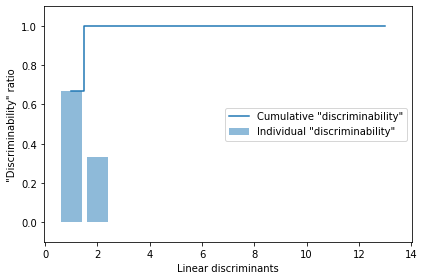

In [31]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center',
        label='Pojedyncza "rozróżnialność"')
plt.step(range(1, 14), cum_discr, where='mid',
         label='Łączna "rozróżnialność"')
plt.ylabel('Współczynnik "rozróżnialności"')
plt.xlabel('Dyskryminanty liniowe')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('rysunki/05_07.png', dpi=300)
plt.show()

In [32]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('Macierz W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


<br>
<br>

## Rzutowanie przykładów na nową przestrzeń cech

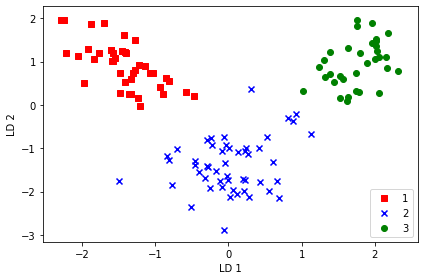

In [33]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],
                X_train_lda[y_train == l, 1] * (-1),
                c=c, label=l, marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.savefig('rysunki/05_08.png', dpi=300)
plt.show()

<br>
<br>

## Implementacja analizy LDA w bibliotece scikit-learn

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

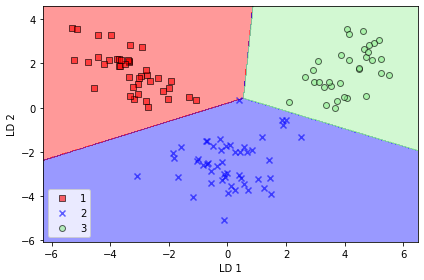

In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('rysunki/05_09.png', dpi=300)
plt.show()

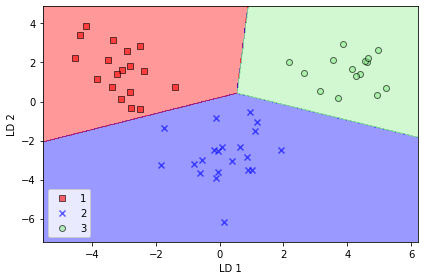

In [36]:
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('rysunki/05_10.png', dpi=300)
plt.show()

<br>
<br>

# Jądrowa analiza głównych składowych jako metoda odwzorowywania nierozdzielnych liniowo klas

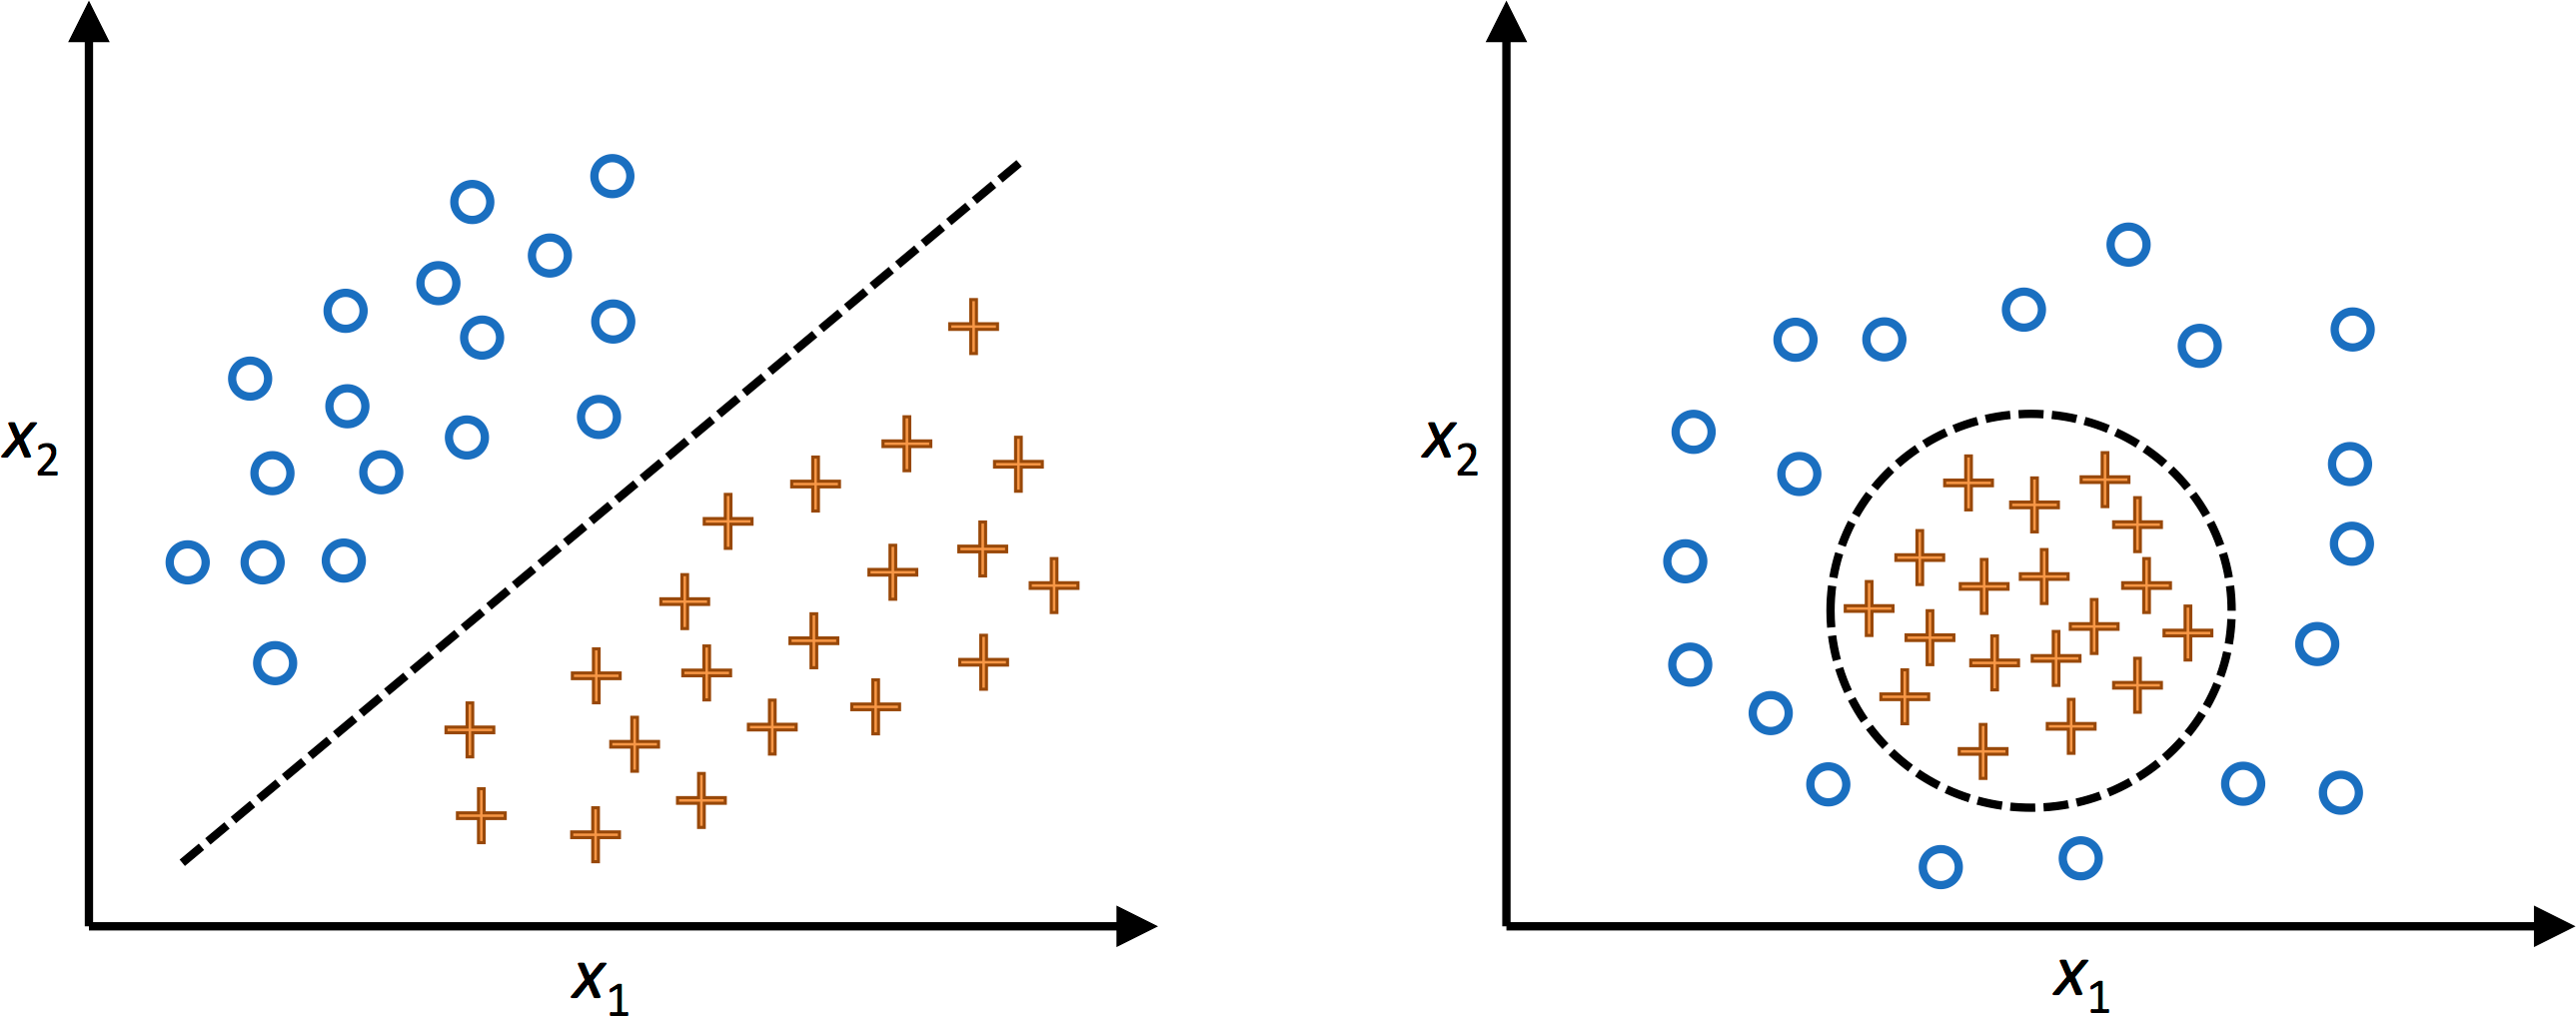

In [4]:
Image(filename='rysunki/05_11.png', width=500) 

## Funkcje jądra oraz sztuczka z funkcją jądra

...

## Implementacja jądrowej analizy głównych składowych w Pythonie

In [38]:
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy as np


from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import exp
else:
    from scipy import exp




def rbf_kernel_pca(X, gamma, n_components):
    """
    Implementacja jądra RBF w analizie PCA.

    Parametry
    ------------
    X: {typ ndarray biblioteki NumPy}, wymiary = [n_próbek, n_cech]
        
    gamma: liczby zmiennoprzecinkowe
      Parametr strojenia jądra RBF
        
    n_components: liczby całkowite
      Liczba zwracanych głównych składowych

    Zwraca
    ------------
     X_pc: {typ ndarray biblioteki NumPy}, wymiary = [n_próbek, k_cech]
       Rzutowany zestaw danych   

    """
    # oblicza kwadraty odległości euklidesowych par
    # w zestawie danych o rozmiarze MxN
    sq_dists = pdist(X, 'sqeuclidean')

    # przekształca wyliczone odległości w macierz kwadratową
    mat_sq_dists = squareform(sq_dists)

    # oblicza symetryczną macierz jądra
    K = exp(-gamma * mat_sq_dists)

    # centruje macierz jądra
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # wydobywa pary własne z centrowanej macierzy jądra
    # funkcja scipy.linalg.eigh zwraca je w malejącej kolejności
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # wybiera k największych wektorów własnych (rzutowanych przykładów)
    X_pc = np.column_stack([eigvecs[:, i]
                            for i in range(n_components)])

    return X_pc

<br>

### Przykład 1. Rozdzielanie sierpowatych kształtów

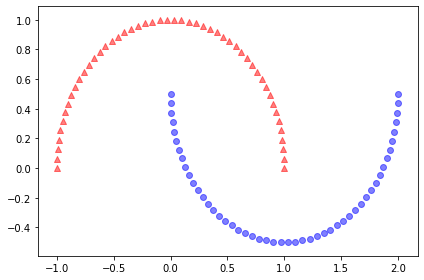

In [39]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('rysunki/05_12.png', dpi=300)
plt.show()

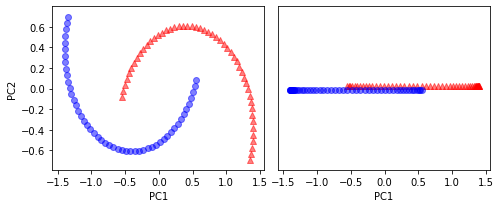

In [40]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('GS1')
ax[0].set_ylabel('GS2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('GS1')

plt.tight_layout()
# plt.savefig('rysunki/05_13.png', dpi=300)
plt.show()

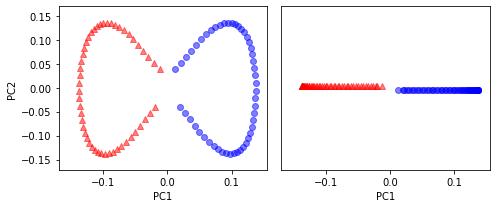

In [41]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50, 1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50, 1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('GS1')
ax[0].set_ylabel('GS2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('GS1')

plt.tight_layout()
# plt.savefig('rysunki/05_14.png', dpi=300)
plt.show()

<br>

### Przykład 2. Rozdzielanie koncentrycznych kręgów

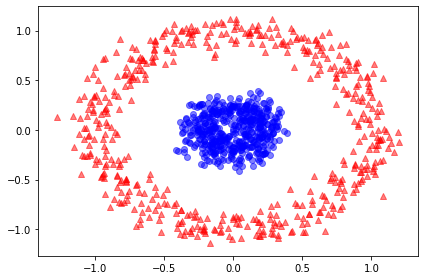

In [42]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()
# plt.savefig('rysunki/05_15.png', dpi=300)
plt.show()

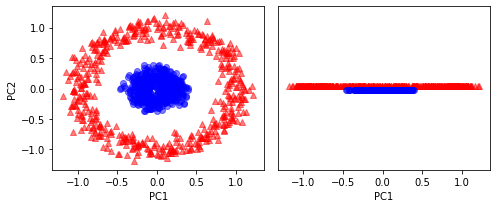

In [43]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('GS1')
ax[0].set_ylabel('GS2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('GS1')

plt.tight_layout()
# plt.savefig('rysunki/05_16.png', dpi=300)
plt.show()

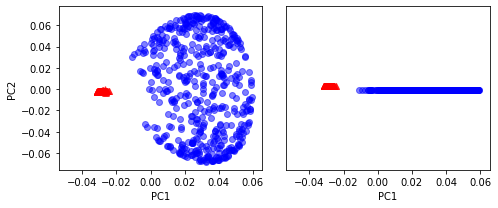

In [44]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('GS1')
ax[0].set_ylabel('GS2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('GS1')

plt.tight_layout()
# plt.savefig('rysunki/05_17.png', dpi=300)
plt.show()

<br>
<br>

## Rzutowanie nowych punktów danych

In [45]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

def rbf_kernel_pca(X, gamma, n_components):
    """
    Implementacja jądra RBF w analizie PCA.

    Parametry
    ------------
    X: {typ ndarray biblioteki NumPy}, wymiary = [n_przykładów, n_cech]
        
    gamma: liczby zmiennoprzecinkowe
      Parametr strojenia jądra RBF
        
    n_components: liczby całkowite
      Liczba zwracanych głównych składowych

    Zwraca
    ------------
     alphas: {typ ndarray biblioteki NumPy}, wymiary = [n_przykładów, k_cech]
       Rzutowany zestaw danych   
     
     lambdas: lista
       Wartości własne

    """
    # oblicza kwadraty odległości euklidesowych par
    # w zestawie danych o rozmiarze MxN
    sq_dists = pdist(X, 'sqeuclidean')

    # przekształca wyliczone odległości na macierz kwadratową
    mat_sq_dists = squareform(sq_dists)

    # oblicza symetryczną macierz jądra
    K = exp(-gamma * mat_sq_dists)

    # wyśrodkowuje macierz jądra
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    # wydobywa pary własne z centrowanej macierzy jądra
    # funkcja scipy.linalg.eigh zwraca je w kolejności rosnącej
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    # wybiera k największych wektorów własnych (rzutowanych przykładów)
    alphas = np.column_stack([eigvecs[:, i]
                              for i in range(n_components)])

    # wybiera odpowiednie wartości własne
    lambdas = [eigvals[i] for i in range(n_components)]

    return alphas, lambdas

In [46]:
X, y = make_moons(n_samples=100, random_state=123)
alphas, lambdas = rbf_kernel_pca(X, gamma=15, n_components=1)

/Users/sebastian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead


In [47]:
x_new = X[25]
x_new

array([1.8713, 0.0093])

In [48]:
x_proj = alphas[25] # pierwotne rzutowanie
x_proj

array([0.0788])

In [49]:
def project_x(x_new, X, gamma, alphas, lambdas):
    pair_dist = np.array([np.sum((x_new - row)**2) for row in X])
    k = np.exp(-gamma * pair_dist)
    return k.dot(alphas / lambdas)

# rzutowanie "nowego" punktu danych
x_reproj = project_x(x_new, X, gamma=15, alphas=alphas, lambdas=lambdas)
x_reproj 

array([0.0788])

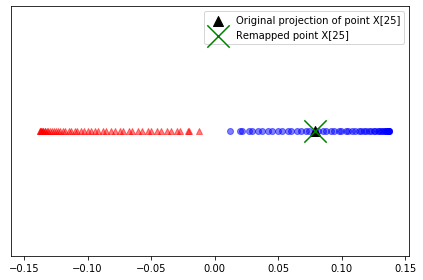

In [50]:
plt.scatter(alphas[y == 0, 0], np.zeros((50)),
            color='red', marker='^', alpha=0.5)
plt.scatter(alphas[y == 1, 0], np.zeros((50)),
            color='blue', marker='o', alpha=0.5)
plt.scatter(x_proj, 0, color='black',
            label='Pierwotne rzutowanie punktu X[25]', marker='^', s=100)
plt.scatter(x_reproj, 0, color='green',
            label='Ponowne odwzorowanie punktu X[25]', marker='x', s=500)
plt.yticks([], [])
plt.legend(scatterpoints=1)

plt.tight_layout()
# plt.savefig('rysunki/05_18.png', dpi=300)
plt.show()

<br>
<br>

## Algorytm jądrowej analizy głównych składowych w bibliotece scikit-learn

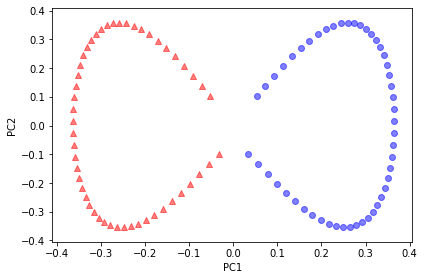

In [51]:
from sklearn.decomposition import KernelPCA

X, y = make_moons(n_samples=100, random_state=123)
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.scatter(X_skernpca[y == 0, 0], X_skernpca[y == 0, 1],
            color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y == 1, 0], X_skernpca[y == 1, 1],
            color='blue', marker='o', alpha=0.5)

plt.xlabel('GS1')
plt.ylabel('GS2')
plt.tight_layout()
# plt.savefig('rysunki/05_19.png', dpi=300)
plt.show()

<br>
<br>

# Podsumowanie

...

---

Czytelnicy mogą zignorować poniższą komórkę.

In [52]:
! python ../.convert_notebook_to_script.py --input r05.ipynb --output r05.py

[NbConvertApp] Converting notebook ch05.ipynb to script
[NbConvertApp] Writing 28174 bytes to ch05.py
